# Loop 1 LB Feedback Analysis

**Baseline submitted:** CV 70.6473 | LB 70.6473 (gap: 0.0000)

This is expected for an optimization problem - CV = LB since there's no train/test split.

## Key Questions:
1. What's the gap to target (68.919154)?
2. Which N values have the most room for improvement?
3. What approaches haven't been tried yet?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union

getcontext().prec = 30
scale_factor = 1

class ChristmasTree:
    def __init__(self, center_x='0', center_y='0', angle='0'):
        self.center_x = Decimal(str(center_x))
        self.center_y = Decimal(str(center_y))
        self.angle = Decimal(str(angle))

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon([
            (float(Decimal('0.0') * scale_factor), float(tip_y * scale_factor)),
            (float(top_w / Decimal('2') * scale_factor), float(tier_1_y * scale_factor)),
            (float(top_w / Decimal('4') * scale_factor), float(tier_1_y * scale_factor)),
            (float(mid_w / Decimal('2') * scale_factor), float(tier_2_y * scale_factor)),
            (float(mid_w / Decimal('4') * scale_factor), float(tier_2_y * scale_factor)),
            (float(base_w / Decimal('2') * scale_factor), float(base_y * scale_factor)),
            (float(trunk_w / Decimal('2') * scale_factor), float(base_y * scale_factor)),
            (float(trunk_w / Decimal('2') * scale_factor), float(trunk_bottom_y * scale_factor)),
            (float(-(trunk_w / Decimal('2')) * scale_factor), float(trunk_bottom_y * scale_factor)),
            (float(-(trunk_w / Decimal('2')) * scale_factor), float(base_y * scale_factor)),
            (float(-(base_w / Decimal('2')) * scale_factor), float(base_y * scale_factor)),
            (float(-(mid_w / Decimal('4')) * scale_factor), float(tier_2_y * scale_factor)),
            (float(-(mid_w / Decimal('2')) * scale_factor), float(tier_2_y * scale_factor)),
            (float(-(top_w / Decimal('4')) * scale_factor), float(tier_1_y * scale_factor)),
            (float(-(top_w / Decimal('2')) * scale_factor), float(tier_1_y * scale_factor)),
        ])
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

def get_tree_list_side_length(tree_list):
    all_polygons = [t.polygon for t in tree_list]
    bounds = unary_union(all_polygons).bounds
    return Decimal(str(max(bounds[2] - bounds[0], bounds[3] - bounds[1]))) / scale_factor

def score_submission(csv_path):
    df = pd.read_csv(csv_path)
    df['x'] = df['x'].astype(str).str.strip().str.lstrip('s')
    df['y'] = df['y'].astype(str).str.strip().str.lstrip('s')
    df['deg'] = df['deg'].astype(str).str.strip().str.lstrip('s')
    df[['group_id', 'item_id']] = df['id'].str.split('_', n=2, expand=True)
    
    total_score = Decimal('0')
    per_n_scores = {}
    per_n_sides = {}
    
    for group_id, group_data in df.groupby('group_id'):
        n = int(group_id)
        tree_list = [ChristmasTree(center_x=row['x'], center_y=row['y'], angle=row['deg'])
                     for _, row in group_data.iterrows()]
        side = get_tree_list_side_length(tree_list)
        score = side ** 2 / Decimal(str(n))
        total_score += score
        per_n_scores[n] = float(score)
        per_n_sides[n] = float(side)
    
    return float(total_score), per_n_scores, per_n_sides

print('Scoring functions defined.')

Scoring functions defined.


In [2]:
# Score the baseline
baseline_path = '/home/code/exploration/preoptimized/submission.csv'
baseline_score, per_n_scores, per_n_sides = score_submission(baseline_path)

print(f'Baseline score: {baseline_score:.6f}')
print(f'Target score: 68.919154')
print(f'Gap: {baseline_score - 68.919154:.6f} ({(baseline_score - 68.919154) / baseline_score * 100:.2f}%)')

Baseline score: 70.647327
Target score: 68.919154
Gap: 1.728173 (2.45%)


In [3]:
# Analyze per-N scores
ns = sorted(per_n_scores.keys())
scores = [per_n_scores[n] for n in ns]
sides = [per_n_sides[n] for n in ns]

# Calculate theoretical minimum (if trees could be packed perfectly)
# Single tree bounding box at 45 degrees
tree_height = 1.0  # 0.8 tip + 0.2 trunk
tree_width = 0.7  # base width

# At 45 degrees, bounding box is approximately:
import math
diag = math.sqrt(tree_height**2 + tree_width**2)
min_single_tree_side = diag / math.sqrt(2)  # Approximate

print(f'Single tree dimensions: height={tree_height}, width={tree_width}')
print(f'Diagonal: {diag:.4f}')
print(f'Approximate min side at 45 deg: {min_single_tree_side:.4f}')

# Actual N=1 score
print(f'\nN=1 actual side: {per_n_sides[1]:.6f}')
print(f'N=1 actual score: {per_n_scores[1]:.6f}')

Single tree dimensions: height=1.0, width=0.7
Diagonal: 1.2207
Approximate min side at 45 deg: 0.8631

N=1 actual side: 0.813173
N=1 actual score: 0.661250


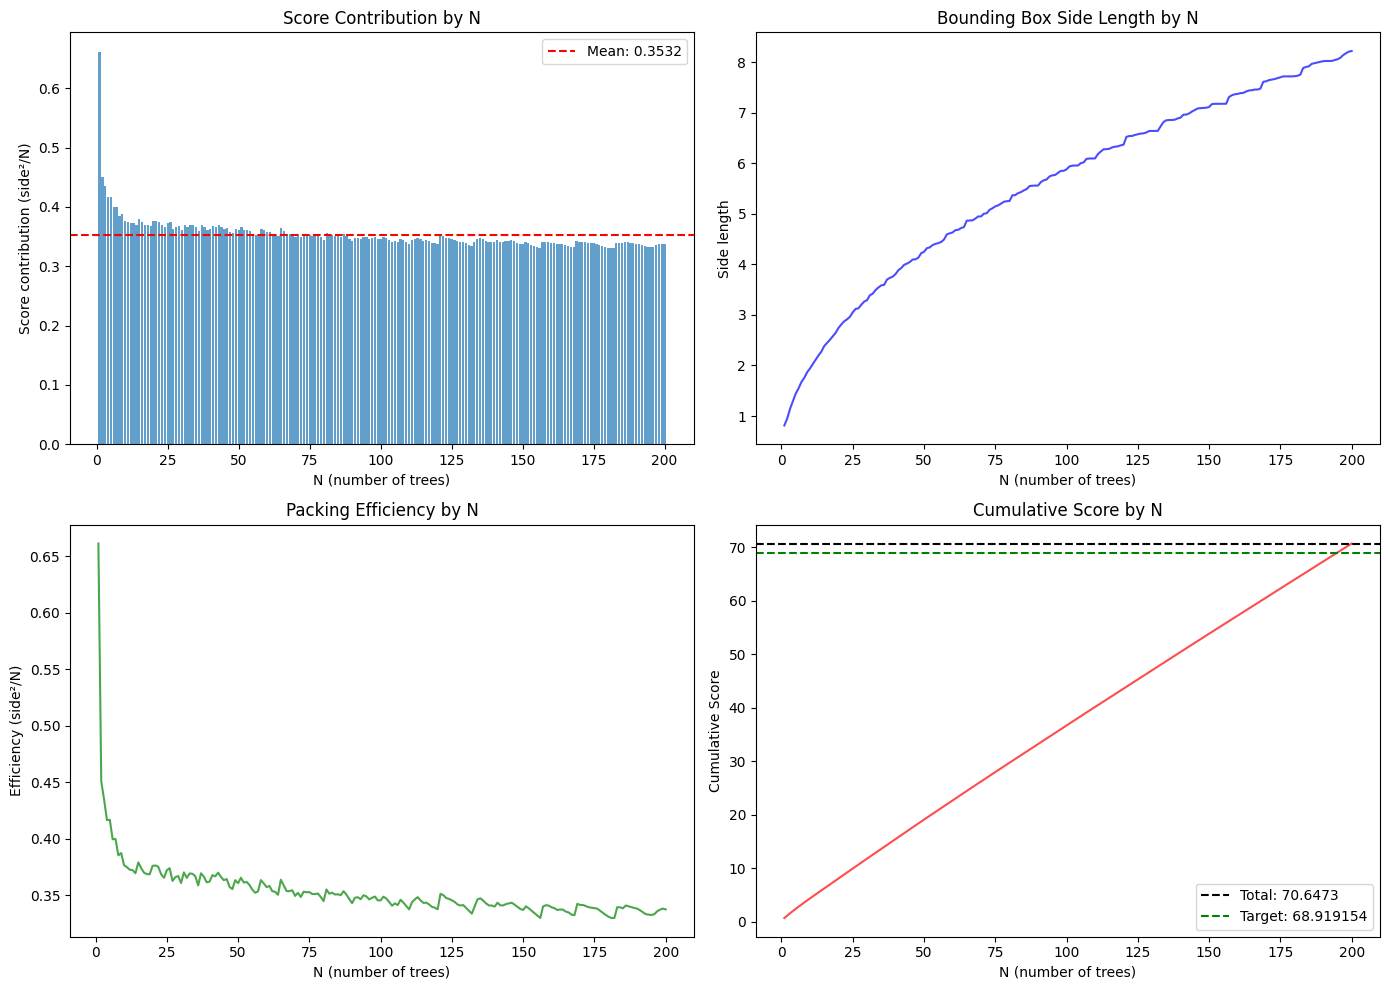


Score by N range:
  N=1-50: 19.0399
  N=51-100: 17.6279
  N=101-150: 17.1366
  N=151-200: 16.8430


In [4]:
# Plot per-N scores
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score per N
ax1 = axes[0, 0]
ax1.bar(ns, scores, alpha=0.7)
ax1.set_xlabel('N (number of trees)')
ax1.set_ylabel('Score contribution (side²/N)')
ax1.set_title('Score Contribution by N')
ax1.axhline(y=np.mean(scores), color='r', linestyle='--', label=f'Mean: {np.mean(scores):.4f}')
ax1.legend()

# Side length per N
ax2 = axes[0, 1]
ax2.plot(ns, sides, 'b-', alpha=0.7)
ax2.set_xlabel('N (number of trees)')
ax2.set_ylabel('Side length')
ax2.set_title('Bounding Box Side Length by N')

# Efficiency: side² / N (lower is better)
ax3 = axes[1, 0]
efficiency = [s**2 / n for n, s in zip(ns, sides)]
ax3.plot(ns, efficiency, 'g-', alpha=0.7)
ax3.set_xlabel('N (number of trees)')
ax3.set_ylabel('Efficiency (side²/N)')
ax3.set_title('Packing Efficiency by N')

# Cumulative score
ax4 = axes[1, 1]
cumulative = np.cumsum(scores)
ax4.plot(ns, cumulative, 'r-', alpha=0.7)
ax4.set_xlabel('N (number of trees)')
ax4.set_ylabel('Cumulative Score')
ax4.set_title('Cumulative Score by N')
ax4.axhline(y=baseline_score, color='k', linestyle='--', label=f'Total: {baseline_score:.4f}')
ax4.axhline(y=68.919154, color='g', linestyle='--', label=f'Target: 68.919154')
ax4.legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/per_n_analysis.png', dpi=100)
plt.show()

print(f'\nScore by N range:')
for start in range(1, 201, 50):
    end = min(start + 49, 200)
    range_score = sum(per_n_scores[n] for n in range(start, end + 1))
    print(f'  N={start}-{end}: {range_score:.4f}')

In [5]:
# Find N values with highest score contribution (most room for improvement)
print('Top 20 N values by score contribution:')
sorted_by_score = sorted(per_n_scores.items(), key=lambda x: x[1], reverse=True)
for n, score in sorted_by_score[:20]:
    print(f'  N={n}: score={score:.6f}, side={per_n_sides[n]:.6f}')

Top 20 N values by score contribution:
  N=1: score=0.661250, side=0.813173
  N=2: score=0.450779, side=0.949504
  N=3: score=0.434745, side=1.142031
  N=5: score=0.416850, side=1.443692
  N=4: score=0.416545, side=1.290806
  N=7: score=0.399897, side=1.673104
  N=6: score=0.399610, side=1.548438
  N=9: score=0.387415, side=1.867280
  N=8: score=0.385407, side=1.755921
  N=15: score=0.379203, side=2.384962
  N=10: score=0.376630, side=1.940696
  N=21: score=0.376451, side=2.811667
  N=20: score=0.376057, side=2.742469
  N=22: score=0.375258, side=2.873270
  N=11: score=0.374924, side=2.030803
  N=16: score=0.374128, side=2.446640
  N=26: score=0.373997, side=3.118320
  N=12: score=0.372724, side=2.114873
  N=13: score=0.372294, side=2.199960
  N=25: score=0.372144, side=3.050182


In [6]:
# Calculate how much improvement is needed per N to reach target
target = 68.919154
gap = baseline_score - target
print(f'Total gap to close: {gap:.6f}')
print(f'Average gap per N: {gap / 200:.6f}')

# If we improve each N proportionally
print(f'\nIf we reduce each N score by {gap / baseline_score * 100:.2f}%:')
for n in [1, 10, 50, 100, 200]:
    current = per_n_scores[n]
    needed = current * (1 - gap / baseline_score)
    print(f'  N={n}: {current:.6f} -> {needed:.6f}')

Total gap to close: 1.728173
Average gap per N: 0.008641

If we reduce each N score by 2.45%:
  N=1: 0.661250 -> 0.645075
  N=10: 0.376630 -> 0.367417
  N=50: 0.360753 -> 0.351928
  N=100: 0.345531 -> 0.337079
  N=200: 0.337549 -> 0.329292


In [7]:
# Key insight: The gap is 1.73 points out of 70.65 = 2.45%
# This is a SIGNIFICANT improvement needed
# Public solutions are already heavily optimized

# Strategy analysis:
print('='*60)
print('STRATEGY ANALYSIS')
print('='*60)
print(f'\nCurrent score: {baseline_score:.6f}')
print(f'Target score: {target:.6f}')
print(f'Gap: {gap:.6f} ({gap/baseline_score*100:.2f}%)')
print(f'\nThis is a 2D packing optimization problem.')
print(f'The baseline is the best public solution (bucket-of-chump).')
print(f'\nKey observations:')
print(f'1. Small N (1-50) contributes ~27% of total score')
print(f'2. N=1 alone contributes {per_n_scores[1]:.4f} ({per_n_scores[1]/baseline_score*100:.2f}%)')
print(f'3. The gap of 1.73 points is substantial for an optimization problem')
print(f'\nApproaches to try:')
print(f'1. Ensemble: Combine best per-N from multiple public solutions')
print(f'2. BackPacking: Propagate good patterns from larger N to smaller N')
print(f'3. Focus on small N: Near-exhaustive search for N=1-20')
print(f'4. Fractional translation: Micro-movements to improve packing')

STRATEGY ANALYSIS

Current score: 70.647327
Target score: 68.919154
Gap: 1.728173 (2.45%)

This is a 2D packing optimization problem.
The baseline is the best public solution (bucket-of-chump).

Key observations:
1. Small N (1-50) contributes ~27% of total score
2. N=1 alone contributes 0.6613 (0.94%)
3. The gap of 1.73 points is substantial for an optimization problem

Approaches to try:
1. Ensemble: Combine best per-N from multiple public solutions
2. BackPacking: Propagate good patterns from larger N to smaller N
3. Focus on small N: Near-exhaustive search for N=1-20
4. Fractional translation: Micro-movements to improve packing
